# Variational Autoencoders

In [78]:
#imports
from tensorflow.keras.layers import Dense, Activation, Add, Multiply, Input, Reshape, Lambda, Concatenate
from tensorflow.keras.models import Model
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

#get data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.
x_test = x_test.reshape(-1, 784).astype('float32') / 255.

#x_train = np.expand_dims(x_train, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)

#set parameters
middle_layer = 300
latent_size = 3
EPOCHS = 50
BATCH_SIZE = 1000


In [3]:
x_train.shape

(60000, 784)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding1 (Dense)               (None, 512)          401920      input[0][0]                      
__________________________________________________________________________________________________
encoding2_Sigma (Dense)         (None, 3)            1539        encoding1[0][0]                  
__________________________________________________________________________________________________
encoding2_Mu (Dense)            (None, 3)            1539        encoding1[0][0]                  
____________________________________________________________________________________________

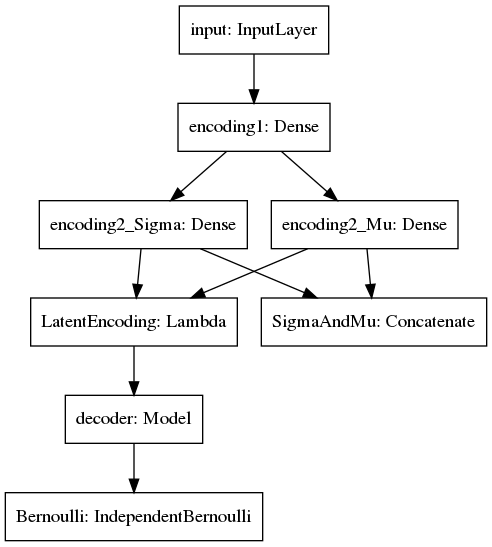

In [28]:
#create model
inp = Input(shape=(784,), name="input")
enc = Dense(middle_layer, activation='relu', name="encoding1")(inp)
enc_sigma = Dense(latent_size, name="encoding2_Sigma")(enc)
enc_mu = Dense(latent_size, name="encoding2_Mu")(enc)
#eps = Input(tensor=tfp.Normal().sample(latent_size))
#tmp = Multiply()([enc_sigma, eps])
#latent = Add()([enc_mu, tmp])
concatenated_latent = Concatenate(axis=1,name="SigmaAndMu")([enc_sigma, enc_mu])
latent = Lambda(lambda ms: tfp.distributions.MultivariateNormalDiag(loc=ms[0], scale_diag=ms[1]).sample(), name="LatentEncoding")([enc_mu, enc_sigma])

encoder = Model(inputs=inp, outputs=latent, name="encoder")

inp_from_latent = Input(shape=[latent_size], name="input2")
dec = Dense(middle_layer, activation='relu', name="decoding1")(inp_from_latent)
dec = Dense(784, activation='relu', name="decoding2")(dec)
out_dist = Reshape([28, 28, 1], name="Reshape")(dec)
#out_dist_joint = Lambda(lambda decoded: tfp.distributions.Independent(tfp.distributions.Bernoulli(logits=out_dist), 2), output_shape=(1,1), name="BernoulliProbability")(dec)
#we cant do the lambda layer above, because it wont return anything; just instantiates distro. 
#BUT, there exists an actual tfp layer!! So apparently, you CAN return a distribution! :)
out_dist_joint = tfp.layers.IndependentBernoulli((28,28,1), tfp.distributions.Bernoulli.logits, name="Bernoulli")


decoder = Model(inputs=inp_from_latent, outputs=out_dist, name="decoder")

vae_model = Model(inputs=encoder.inputs, outputs=[concatenated_latent, out_dist_joint(decoder(latent))])#out_dist_joint(out_dist)])

vae_model.summary()
plot_model(vae_model, to_file='vae_model_bernoulli.png')

#kl_loss = tf.reduce_mean(- 0.5 * tf.reduce_sum(1 + enc_sigma - tf.square(enc_mu) - tf.exp(enc_sigma), axis=-1))
#reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inp, dec) * 784) #vae_model.outputs[0].log_prob(inp), axis=-1)
#vae_model.add_loss(kl_loss)
#vae_model.add_loss(reconstruction_loss)

In [4]:
print(tf.keras.backend.image_data_format())

channels_last


In [83]:
#create model
inp = Input(shape=(784,), name="input")
enc = Dense(middle_layer, activation='tanh', name="encoding1")(inp)
enc_sigma = Dense(latent_size, name="Sigma")(enc)
enc_mu = Dense(latent_size, name="Mu")(enc)
#latent = Lambda(lambda ms: tfp.distributions.MultivariateNormalDiag(loc=ms[0], scale_diag=ms[1]).sample(sample_shape=tf.shape(enc_mu)), name="LatentEncoding")([enc_mu, enc_sigma])
latent = Lambda(lambda mu: mu[0] + tf.exp(0.5 * mu[1]) * tf.random_normal(shape=tf.shape(mu[0])), name="LatentEncoding")((enc_mu, enc_sigma))

encoder = Model(inputs=inp, outputs=[enc_mu, enc_sigma, latent], name="Encoder")

inp_from_latent = Input(shape=latent_size, name="input2")
dec1 = Dense(middle_layer, activation='tanh', name="decoding1")(inp_from_latent)
dec = Dense(784, activation='sigmoid', name="decoding2")(dec1)
#out_dist_joint = tfp.layers.IndependentBernoulli([784], tfp.distributions.Bernoulli.logits, name="Bernoulli")

decoder = Model(inputs=inp_from_latent, outputs=dec, name="Decoder")

outs = decoder(latent)

#vae_model = Model(inputs=inp, outputs=[enc_mu, enc_sigma, out_dist_joint(dec)], name="VAE")
vae_model = Model(inputs=inp, outputs=outs, name="VAE")

vae_model.summary()
plot_model(vae_model, to_file='vae_model.png')



kl = tf.reduce_mean(- 0.5 * tf.reduce_sum(1 + enc_sigma - tf.square(enc_mu) - tf.exp(enc_sigma), axis=-1))
reconstruct = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inp, outs) * 784) #vae_model.output.log_prob(inp), axis=-1)
vae_model.add_loss(kl)
vae_model.add_loss(reconstruct)

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding1 (Dense)               (None, 300)          235500      input[0][0]                      
__________________________________________________________________________________________________
Mu (Dense)                      (None, 3)            903         encoding1[0][0]                  
__________________________________________________________________________________________________
Sigma (Dense)                   (None, 3)            903         encoding1[0][0]                  
________________________________________________________________________________________________

In [ ]:
#we need multiple losses:
def reconstruction_loss(y_true, y_pred):
    return - tf.reduce_mean(y_pred.log_prob(y_true), axis=-1)
def KL_loss_sigma(y_true, y_pred):
    return tf.reduce_mean(0.5*(-tf.reduce_sum(y_pred, axis=-1) + tf.reduce_sum(tf.exp(y_pred), axis=-1)))
def KL_loss_mu(y_true, y_pred):
    return tf.reduce_mean(0.5*(tf.reduce_sum(tf.square(y_pred), axis=-1) - tf.cast(tf.size(y_pred), tf.dtypes.float32)))

dummy = np.zeros(latent_size)
losses = {"Bernoulli" : reconstruction_loss,
          "Sigma" : KL_loss_sigma,
          "Mu" : KL_loss_mu}
loss_weights = {"Bernoulli" : 1.0, 
                "Sigma" : 1.0,
                "Mu" : 1.0}


Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding1 (Dense)               (None, 300)          235500      input[0][0]                      
__________________________________________________________________________________________________
Mu (Dense)                      (None, 3)            903         encoding1[0][0]                  
__________________________________________________________________________________________________
Sigma (Dense)                   (None, 3)            903         encoding1[0][0]                  
________________________________________________________________________________________________

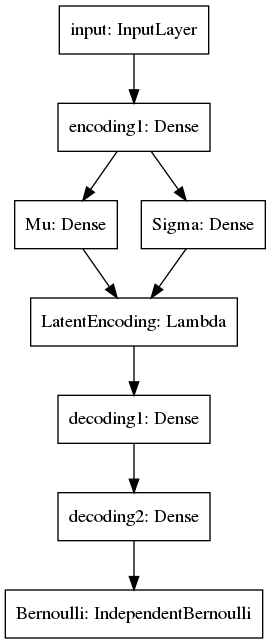

In [34]:
#TEGALE NE RABIS SPLOH!! SAMO ZA SLIKCO JE BLO POGNANO!!!


inp = Input(shape=(784,), name="input")
enc = Dense(middle_layer, activation='relu', name="encoding1")(inp)
enc_sigma = Dense(latent_size, name="Sigma")(enc)
enc_mu = Dense(latent_size, name="Mu")(enc)
#latent = Lambda(lambda ms: tfp.distributions.MultivariateNormalDiag(loc=ms[0], scale_diag=ms[1]).sample(sample_shape=tf.shape(enc_mu)), name="LatentEncoding")([enc_mu, enc_sigma])
latent = Lambda(lambda mu: mu[0] + tf.exp(0.5 * mu[1]) * tf.random_normal(shape=tf.shape(mu[0])), name="LatentEncoding")((enc_mu, enc_sigma))

encoder = Model(inputs=inp, outputs=[enc_mu, enc_sigma, latent])

#inp_from_latent = Input(shape=latent_size, name="input2")
dec1 = Dense(middle_layer, activation='relu', name="decoding1")(latent)
dec = Dense(784, activation='sigmoid', name="decoding2")(dec1)
out_dist_joint = tfp.layers.IndependentBernoulli([784], tfp.distributions.Bernoulli.logits, name="Bernoulli")

#decoder = Model(inputs=inp_from_latent, outputs=dec)

outs = decoder(latent)

vae_model = Model(inputs=inp, outputs=[enc_mu, enc_sigma, out_dist_joint(dec)], name="VAE")
#vae_model = Model(inputs=inp, outputs=outs, name="VAE")

vae_model.summary()
plot_model(vae_model, to_file='vae_model_berni.png')


In [84]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#vae_model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics=["accuracy"])
vae_model.compile(optimizer=opt, metrics=["accuracy"])

calb = EarlyStopping(monitor='val_loss', min_delta=0.2, patience=15, restore_best_weights=True)


#hist = vae_model.fit(x_train, {"Bernoulli": x_train, "Sigma": x_train, "Mu": x_train},
#validation_data=(x_test, {"Bernoulli": x_test, "Sigma": x_test, "Mu": x_test}), epochs=EPOCHS, batch_size=BATCH_SIZE)
hist = vae_model.fit(x_train, None, validation_data=(x_test, None), epochs=300, batch_size=BATCH_SIZE, callbacks=[calb])

W0826 17:19:36.299549 140136269260608 training_utils.py:1101] Output Decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to Decoder.


Train on 60000 samples, validate on 10000 samples
Epoch 1/300
60000/60000 [==============================] - 4s 71us/sample - loss: 276.9055 - val_loss: 206.9550
Epoch 2/300
60000/60000 [==============================] - 3s 45us/sample - loss: 197.3309 - val_loss: 190.3409
Epoch 3/300
60000/60000 [==============================] - 3s 54us/sample - loss: 187.8223 - val_loss: 184.9478
Epoch 4/300
60000/60000 [==============================] - 3s 52us/sample - loss: 184.1689 - val_loss: 182.1499
Epoch 5/300
60000/60000 [==============================] - 3s 45us/sample - loss: 181.9043 - val_loss: 180.1327
Epoch 6/300
60000/60000 [==============================] - 3s 48us/sample - loss: 179.9689 - val_loss: 178.2635
Epoch 7/300
60000/60000 [==============================] - 3s 46us/sample - loss: 178.0171 - val_loss: 176.3436
Epoch 8/300
60000/60000 [==============================] - 3s 46us/sample - loss: 176.0509 - val_loss: 174.5107
Epoch 9/300
60000/60000 [=============================

60000/60000 [==============================] - 3s 44us/sample - loss: 140.2751 - val_loss: 141.0178
Epoch 74/300
60000/60000 [==============================] - 3s 46us/sample - loss: 140.1255 - val_loss: 141.1484
Epoch 75/300
60000/60000 [==============================] - 3s 44us/sample - loss: 139.9467 - val_loss: 140.6695
Epoch 76/300
60000/60000 [==============================] - 3s 47us/sample - loss: 139.8245 - val_loss: 140.5070
Epoch 77/300
60000/60000 [==============================] - 3s 46us/sample - loss: 139.6135 - val_loss: 140.4220
Epoch 78/300
60000/60000 [==============================] - 3s 46us/sample - loss: 139.4548 - val_loss: 140.3344
Epoch 79/300
60000/60000 [==============================] - 3s 47us/sample - loss: 139.3350 - val_loss: 140.1779
Epoch 80/300
60000/60000 [==============================] - 4s 59us/sample - loss: 139.1733 - val_loss: 140.0495
Epoch 81/300
60000/60000 [==============================] - 3s 44us/sample - loss: 139.0579 - val_loss: 139.9

60000/60000 [==============================] - 3s 44us/sample - loss: 133.7895 - val_loss: 136.8339
Epoch 146/300
60000/60000 [==============================] - 3s 44us/sample - loss: 133.7515 - val_loss: 136.8146
Epoch 147/300
60000/60000 [==============================] - 3s 44us/sample - loss: 133.6703 - val_loss: 136.9509
Epoch 148/300
60000/60000 [==============================] - 3s 44us/sample - loss: 133.6730 - val_loss: 136.8489
Epoch 149/300
60000/60000 [==============================] - 3s 44us/sample - loss: 133.6565 - val_loss: 136.8378
Epoch 150/300
60000/60000 [==============================] - 3s 44us/sample - loss: 133.6374 - val_loss: 136.8949
Epoch 151/300
60000/60000 [==============================] - 3s 44us/sample - loss: 133.5128 - val_loss: 136.7801
Epoch 152/300
60000/60000 [==============================] - 3s 45us/sample - loss: 133.4468 - val_loss: 136.8629
Epoch 153/300
60000/60000 [==============================] - 3s 44us/sample - loss: 133.4259 - val_los

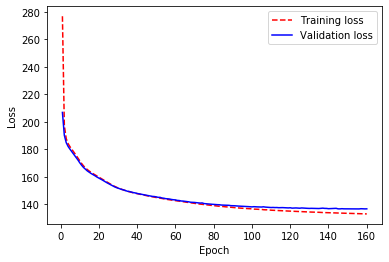

In [85]:
plot_history(hist.history)

In [7]:
def plot_history(history, what='loss', title=""):
    # Visualize loss history
    epoch_count = [i+1 for i in range(len(history[what]))]
    plt.plot(epoch_count, history[what], 'r--')
    if ('val_'+what) in history:
        plt.plot(epoch_count, history['val_'+what], 'b-')
        plt.legend(['Training '+what, 'Validation '+what])
    plt.xlabel('Epoch')
    plt.ylabel(what.capitalize())
    plt.title(title.capitalize())
    plt.show();

In [71]:
#computing loss and generating images:
x_out = vae_model.predict(x_test)
mu, sigma, x_latent = encoder.predict(x_test)

In [72]:
def np_sigmoid(x):
    return 1. / (1. + np.exp(-x))
def np_binary_crossentropy(target, output, from_logits=False):
    if not from_logits:
        output = np.clip(output, 1e-7, 1 - 1e-7)
        output = np.log(output / (1 - output))
    return (target * -np.log(np_sigmoid(output)) + (1 - target) * -np.log(1 - np_sigmoid(output)))

bce_pred = np.mean(np.sum(np_binary_crossentropy(x_test, x_out), axis=-1))

kl_loss_pred = 1 + sigma - np.square(mu) - np.exp(sigma)
kl_loss_pred = np.mean((-0.5 * np.sum(kl_loss_pred, axis=-1)))
print('test reconstruction loss =', round(bce_pred, 2))
print('test KL loss =', round(kl_loss_pred, 2))
print('total test loss =', round(bce_pred + kl_loss_pred, 2))

test reconstruction loss = 77.06
test KL loss = 25.33
total test loss = 102.39


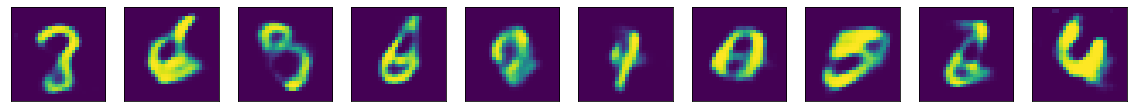

In [73]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    ax = plt.subplot(1, 10, i + 1)
    xx = decoder.predict(np.random.normal(size=(1, latent_size))).reshape(28, 28)
    plt.imshow(xx)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

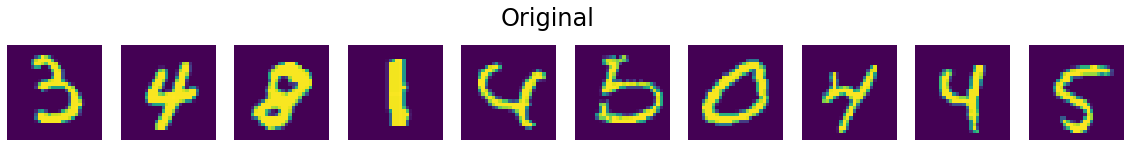

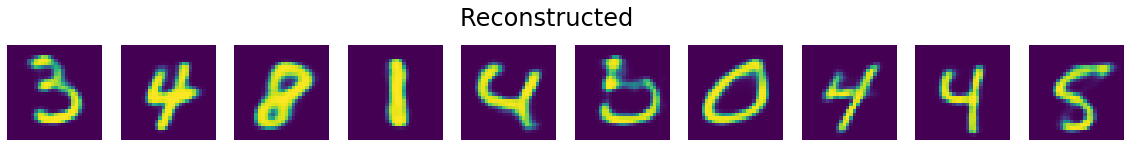

In [76]:
ind = np.random.permutation(x_test.shape[0])

plt.figure(figsize = (20,2.5))
for i in range(n):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[ind[i],:].reshape(28,28))
    plt.axis('off')
plt.suptitle("Original", fontsize=24)
plt.show

plt.figure(figsize = (20,2.5))
for i in range(n):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_out[ind[i],:].reshape(28,28))
    plt.axis('off')
plt.suptitle("Reconstructed", fontsize=24)
plt.show()